In [1]:
# 📦 Imports
import os, cv2, numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
from tensorflow.keras import layers, Input, Model

# 📂 Dataset path
DATASET_DIR = '../../ProcessedFusionFull'
CLASSES = ['Drowsy', 'NonDrowsy']
IMG_SIZE = 256
BATCH_SIZE = 16
EPOCHS = 15

# 🧠 Custom Data Generator
class FusionDataGenerator(Sequence):
    def __init__(self, base_dir, keys, label_dict, batch_size=8, img_size=128, shuffle=True):
        self.face_dir = {cls: os.path.join(base_dir, cls, 'face') for cls in CLASSES}
        self.dot_dir  = {cls: os.path.join(base_dir, cls, 'dotmap') for cls in CLASSES}
        self.lmk_dir  = {cls: os.path.join(base_dir, cls, 'landmark') for cls in CLASSES}
        self.keys = keys
        self.label_dict = label_dict
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.keys) // self.batch_size

    def __getitem__(self, idx):
        batch_keys = self.keys[idx * self.batch_size:(idx + 1) * self.batch_size]
        Xf, Xd, Xm, y = [], [], [], []

        for key in batch_keys:
            label = self.label_dict[key]
            cls = CLASSES[label]
            face = cv2.imread(os.path.join(self.face_dir[cls], key + '.png'), cv2.IMREAD_GRAYSCALE)
            dot  = cv2.imread(os.path.join(self.dot_dir[cls], key + '.png'), cv2.IMREAD_GRAYSCALE)
            lmk  = np.load(os.path.join(self.lmk_dir[cls], key + '.npy'))

            if face is None or dot is None or lmk.shape[0] != 478:
                continue

            face = cv2.resize(face, (self.img_size, self.img_size)) / 255.0
            dot  = cv2.resize(dot,  (self.img_size, self.img_size)) / 255.0

            Xf.append(face[..., np.newaxis])
            Xd.append(dot[..., np.newaxis])
            Xm.append(lmk.flatten())
            y.append(label)

        return {
            'face_in': np.array(Xf, dtype=np.float32),
            'dot_in':  np.array(Xd, dtype=np.float32),
            'lmk_in':  np.array(Xm, dtype=np.float32)
        }, np.array(y, dtype=np.float32)


    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.keys)

# 🏷️ Create label dictionary
label_dict = {}
for idx, cls in enumerate(CLASSES):
    face_path = os.path.join(DATASET_DIR, cls, 'face')
    for fname in os.listdir(face_path):
        if fname.endswith('.png'):
            key = os.path.splitext(fname)[0]
            label_dict[key] = idx

# 🔀 Split data
keys = list(label_dict.keys())
train_keys, val_keys = train_test_split(keys, test_size=0.1, stratify=[label_dict[k] for k in keys], random_state=42)

# 📤 Create generators
train_gen = FusionDataGenerator(DATASET_DIR, train_keys, label_dict, batch_size=BATCH_SIZE, img_size=IMG_SIZE)
val_gen   = FusionDataGenerator(DATASET_DIR, val_keys, label_dict, batch_size=BATCH_SIZE, img_size=IMG_SIZE)

# 🧠 Model definition
landmark_dim = 478 * 2

face_in = Input(shape=(IMG_SIZE, IMG_SIZE, 1), name='face_in')
x1 = layers.Conv2D(32, 3, activation='relu')(face_in)
x1 = layers.MaxPooling2D()(x1)
x1 = layers.Conv2D(64, 3, activation='relu')(x1)
x1 = layers.GlobalAveragePooling2D()(x1)
x1 = layers.Dense(128, activation='relu')(x1)

dot_in = Input(shape=(IMG_SIZE, IMG_SIZE, 1), name='dot_in')
x2 = layers.Conv2D(32, 3, activation='relu')(dot_in)
x2 = layers.MaxPooling2D()(x2)
x2 = layers.Conv2D(64, 3, activation='relu')(x2)
x2 = layers.GlobalAveragePooling2D()(x2)
x2 = layers.Dense(128, activation='relu')(x2)

lmk_in = Input(shape=(landmark_dim,), name='lmk_in')
x3 = layers.Dense(128, activation='relu')(lmk_in)
x3 = layers.Dense(64, activation='relu')(x3)

merged = layers.concatenate([x1, x2, x3])
z = layers.Dense(64, activation='relu')(merged)
z = layers.Dropout(0.4)(z)
out = layers.Dense(1, activation='sigmoid', name='out')(z)

model = Model(inputs=[face_in, dot_in, lmk_in], outputs=out)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# 🚀 Train
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS
)

# 💾 Save
model.save("fatigue_fusion_model_generator_90.h5")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ face_in             │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_in (InputLayer) │ (None, 256, 256,  │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 254, 254,  │        320 │ face_in[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 254, 254,  │        320 │ dot_in[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 127, 127,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 127, 127,  │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 125, 125,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 125, 125,  │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lmk_in (InputLayer) │ (None, 956)       │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ conv2d_1[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ conv2d_3[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │    122,496 │ lmk_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      8,320 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │      8,320 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 320)       │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ dense_1[0][0],    │
│                     │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │     20,544 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ out (Dense)         │ (None, 1)         │         65 │ dropout[0][0]   

 Total params: 205,633 (803.25 KB)

 Trainable params: 205,633 (803.25 KB)

 Non-trainable params: 0 (0.00 B)

c:\Users\aqilw\Desktop\FYP DEGREE\FatigueFYP\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 1231s 854ms/step - accuracy: 0.6052 - loss: 0.6495 - val_accuracy: 0.7787 - val_loss: 0.4383
Epoch 2/15
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 640s 445ms/step - accuracy: 0.8254 - loss: 0.3937 - val_accuracy: 0.8538 - val_loss: 0.3347
Epoch 3/15
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 639s 444ms/step - accuracy: 0.8900 - loss: 0.2793 - val_accuracy: 0.9383 - val_loss: 0.1596
Epoch 4/15
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 637s 443ms/step - accuracy: 0.9150 - loss: 0.2149 - val_accuracy: 0.9489 - val_loss: 0.1258
Epoch 5/15
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 639s 444ms/step - accuracy: 0.9356 - loss: 0.1732 - val_accuracy: 0.9367 - val_loss: 0.1486
Epoch 6/15
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 637s 443ms/step - accuracy: 0.9454 - loss: 0.1492 - val_accuracy: 0.9646 - val_loss: 0.0884
Epoch 7/15
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 637s 443ms/step - accuracy: 0.9560 - loss: 0.1250 - val_accuracy: 0.9642 - val_loss: 0.1064
Epoch 8/15
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 637s 443ms/step - a

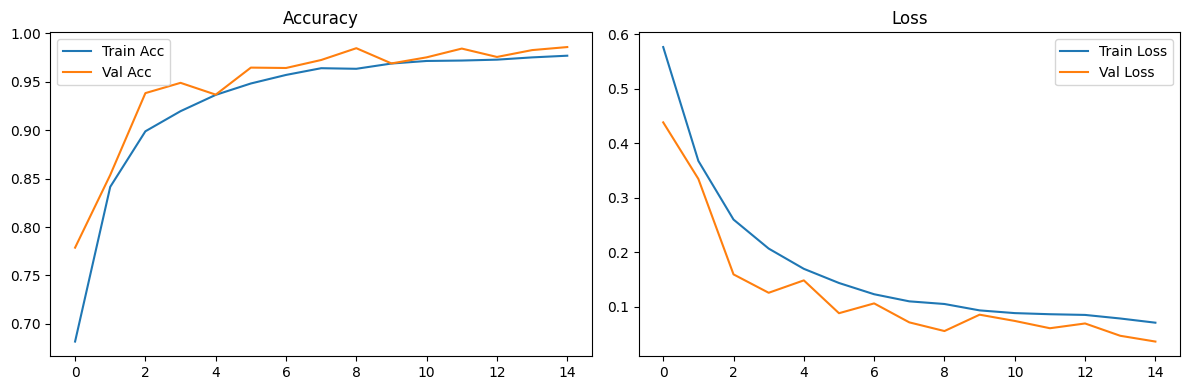

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()
    


✅ Final Training Accuracy: 0.9769
❌ Final Training Loss: 0.0710
159/159 ━━━━━━━━━━━━━━━━━━━━ 20s 127ms/step - accuracy: 0.9854 - loss: 0.0384

✅ Final Validation Accuracy: 0.9858
❌ Final Validation Loss: 0.0365


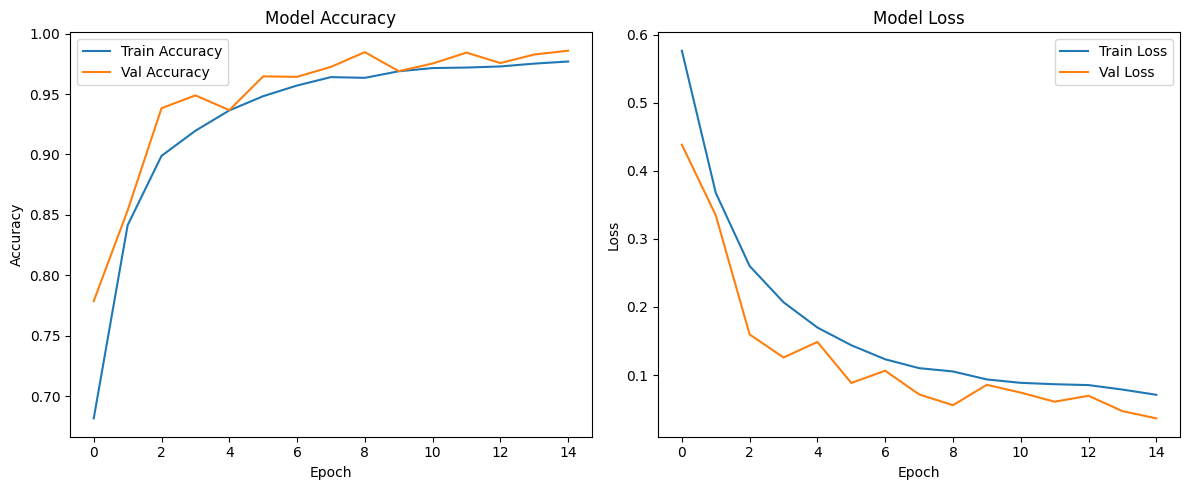

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

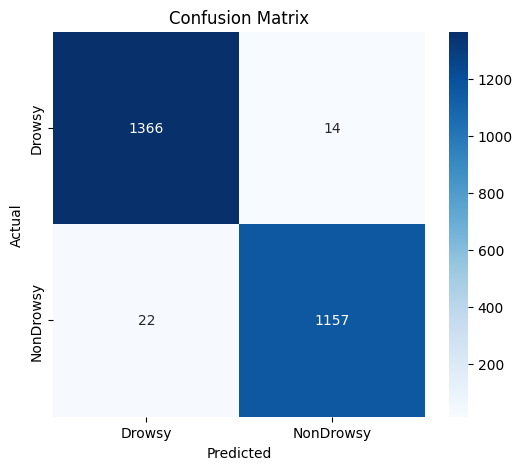

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# ✅ Extract final training accuracy & loss from history
final_train_acc = history.history['accuracy'][-1]
final_train_loss = history.history['loss'][-1]

print(f"\n✅ Final Training Accuracy: {final_train_acc:.4f}")
print(f"❌ Final Training Loss: {final_train_loss:.4f}")

# ✅ Evaluate final model on validation generator
val_loss, val_acc = model.evaluate(val_gen, verbose=1)
print(f"\n✅ Final Validation Accuracy: {val_acc:.4f}")
print(f"❌ Final Validation Loss: {val_loss:.4f}")

# 📊 Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# 🧠 Predict and generate classification report
y_true = []
y_pred = []

for X_batch, y_batch in val_gen:
    preds = model.predict(X_batch)
    y_true.extend(y_batch)
    y_pred.extend((preds > 0.5).astype(int).flatten())
    if len(y_true) >= len(val_keys):
        break

print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=CLASSES))

# 🔳 Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [4]:
# 📦 Imports
import os, cv2, numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
from tensorflow.keras import layers, Input, Model

# 📂 Dataset path
DATASET_DIR = '../../ProcessedFusionFull'
CLASSES = ['Drowsy', 'NonDrowsy']
IMG_SIZE = 256
BATCH_SIZE = 16
EPOCHS = 15

# 🧠 Custom Data Generator
class FusionDataGenerator(Sequence):
    def __init__(self, base_dir, keys, label_dict, batch_size=8, img_size=128, shuffle=True):
        self.face_dir = {cls: os.path.join(base_dir, cls, 'face') for cls in CLASSES}
        self.dot_dir  = {cls: os.path.join(base_dir, cls, 'dotmap') for cls in CLASSES}
        self.lmk_dir  = {cls: os.path.join(base_dir, cls, 'landmark') for cls in CLASSES}
        self.keys = keys
        self.label_dict = label_dict
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.keys) // self.batch_size

    def __getitem__(self, idx):
        batch_keys = self.keys[idx * self.batch_size:(idx + 1) * self.batch_size]
        Xf, Xd, Xm, y = [], [], [], []

        for key in batch_keys:
            label = self.label_dict[key]
            cls = CLASSES[label]
            face = cv2.imread(os.path.join(self.face_dir[cls], key + '.png'), cv2.IMREAD_GRAYSCALE)
            dot  = cv2.imread(os.path.join(self.dot_dir[cls], key + '.png'), cv2.IMREAD_GRAYSCALE)
            lmk  = np.load(os.path.join(self.lmk_dir[cls], key + '.npy'))

            if face is None or dot is None or lmk.shape[0] != 478:
                continue

            face = cv2.resize(face, (self.img_size, self.img_size)) / 255.0
            dot  = cv2.resize(dot,  (self.img_size, self.img_size)) / 255.0

            Xf.append(face[..., np.newaxis])
            Xd.append(dot[..., np.newaxis])
            Xm.append(lmk.flatten())
            y.append(label)

        return {
            'face_in': np.array(Xf, dtype=np.float32),
            'dot_in':  np.array(Xd, dtype=np.float32),
            'lmk_in':  np.array(Xm, dtype=np.float32)
        }, np.array(y, dtype=np.float32)


    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.keys)

# 🏷️ Create label dictionary
label_dict = {}
for idx, cls in enumerate(CLASSES):
    face_path = os.path.join(DATASET_DIR, cls, 'face')
    for fname in os.listdir(face_path):
        if fname.endswith('.png'):
            key = os.path.splitext(fname)[0]
            label_dict[key] = idx

# 🔀 Split data
keys = list(label_dict.keys())
train_keys, val_keys = train_test_split(keys, test_size=0.2, stratify=[label_dict[k] for k in keys], random_state=42)

# 📤 Create generators
train_gen = FusionDataGenerator(DATASET_DIR, train_keys, label_dict, batch_size=BATCH_SIZE, img_size=IMG_SIZE)
val_gen   = FusionDataGenerator(DATASET_DIR, val_keys, label_dict, batch_size=BATCH_SIZE, img_size=IMG_SIZE)

# 🧠 Model definition
landmark_dim = 478 * 2

face_in = Input(shape=(IMG_SIZE, IMG_SIZE, 1), name='face_in')
x1 = layers.Conv2D(32, 3, activation='relu')(face_in)
x1 = layers.MaxPooling2D()(x1)
x1 = layers.Conv2D(64, 3, activation='relu')(x1)
x1 = layers.GlobalAveragePooling2D()(x1)
x1 = layers.Dense(128, activation='relu')(x1)

dot_in = Input(shape=(IMG_SIZE, IMG_SIZE, 1), name='dot_in')
x2 = layers.Conv2D(32, 3, activation='relu')(dot_in)
x2 = layers.MaxPooling2D()(x2)
x2 = layers.Conv2D(64, 3, activation='relu')(x2)
x2 = layers.GlobalAveragePooling2D()(x2)
x2 = layers.Dense(128, activation='relu')(x2)

lmk_in = Input(shape=(landmark_dim,), name='lmk_in')
x3 = layers.Dense(128, activation='relu')(lmk_in)
x3 = layers.Dense(64, activation='relu')(x3)

merged = layers.concatenate([x1, x2, x3])
z = layers.Dense(64, activation='relu')(merged)
z = layers.Dropout(0.4)(z)
out = layers.Dense(1, activation='sigmoid', name='out')(z)

model = Model(inputs=[face_in, dot_in, lmk_in], outputs=out)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# 🚀 Train
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS
)

# 💾 Save
model.save("fatigue_fusion_model_generator_80.h5")


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ face_in             │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_in (InputLayer) │ (None, 256, 256,  │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 254, 254,  │        320 │ face_in[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 254, 254,  │        320 │ dot_in[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 127, 127,  │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 127, 127,  │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 125, 125,  │     18,496 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 125, 125,  │     18,496 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lmk_in (InputLayer) │ (None, 956)       │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ conv2d_5[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ conv2d_7[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │    122,496 │ lmk_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │      8,320 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │      8,320 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │      8,256 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 320)       │          0 │ dense_5[0][0],    │
│ (Concatenate)       │                   │            │ dense_6[0][0],    │
│                     │                   │            │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 64)        │     20,544 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ out (Dense)         │ (None, 1)         │         65 │ dropout_1[0][0] 

 Total params: 205,633 (803.25 KB)

 Trainable params: 205,633 (803.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15


c:\Users\aqilw\Desktop\FYP DEGREE\FatigueFYP\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1279/1279 ━━━━━━━━━━━━━━━━━━━━ 580s 452ms/step - accuracy: 0.5853 - loss: 0.6698 - val_accuracy: 0.7394 - val_loss: 0.4929
Epoch 2/15
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 579s 453ms/step - accuracy: 0.7623 - loss: 0.4924 - val_accuracy: 0.8815 - val_loss: 0.3196
Epoch 3/15
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 578s 452ms/step - accuracy: 0.8514 - loss: 0.3485 - val_accuracy: 0.9158 - val_loss: 0.2218
Epoch 4/15
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 579s 452ms/step - accuracy: 0.8968 - loss: 0.2641 - val_accuracy: 0.9379 - val_loss: 0.1637
Epoch 5/15
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 590s 462ms/step - accuracy: 0.9176 - loss: 0.2193 - val_accuracy: 0.9459 - val_loss: 0.1557
Epoch 6/15
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 590s 461ms/step - accuracy: 0.9390 - loss: 0.1660 - val_accuracy: 0.9565 - val_loss: 0.1236
Epoch 7/15
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 587s 459ms/step - accuracy: 0.9524 - loss: 0.1368 - val_accuracy: 0.9706 - val_loss: 0.0849
Epoch 8/15
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 587s 459ms/step - accuracy: 0.9

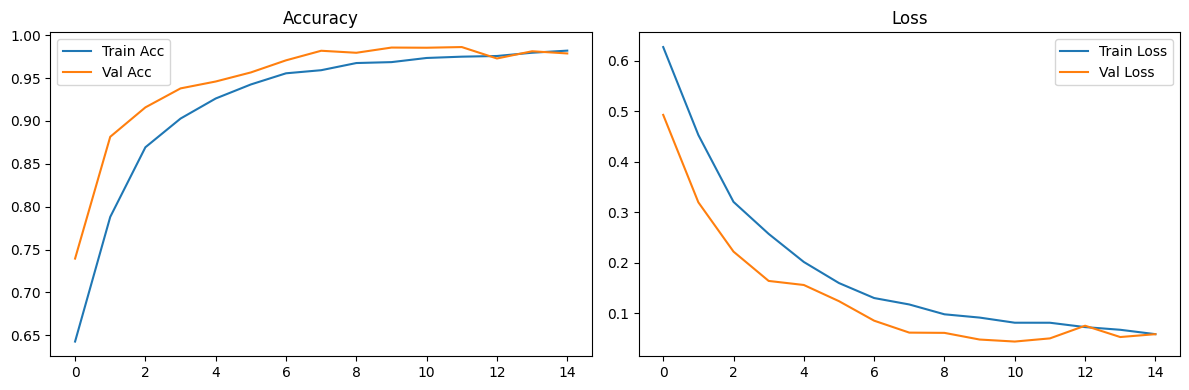

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()
    


✅ Final Training Accuracy: 0.9819
❌ Final Training Loss: 0.0582
319/319 ━━━━━━━━━━━━━━━━━━━━ 39s 121ms/step - accuracy: 0.9805 - loss: 0.0568

✅ Final Validation Accuracy: 0.9786
❌ Final Validation Loss: 0.0580


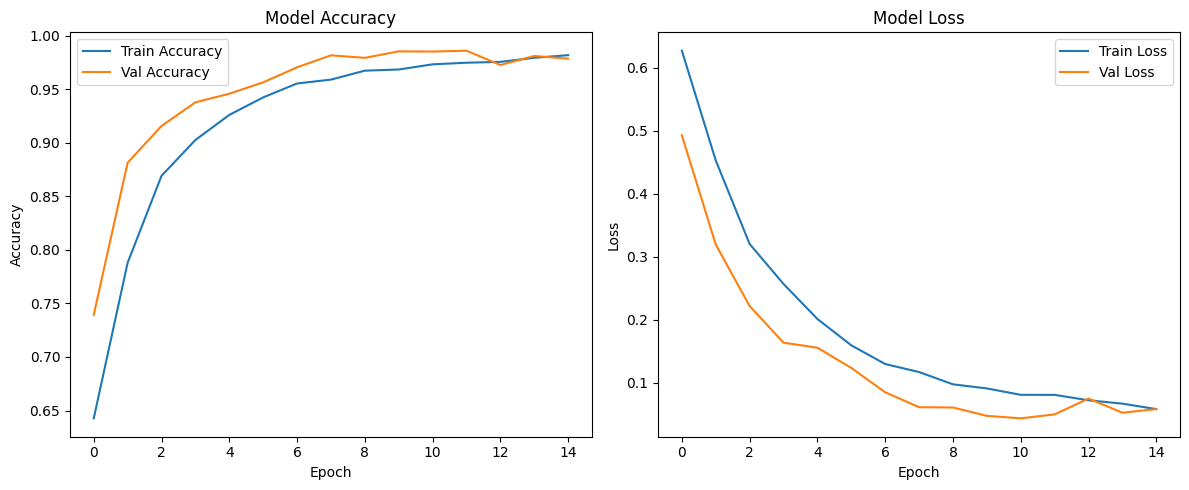

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

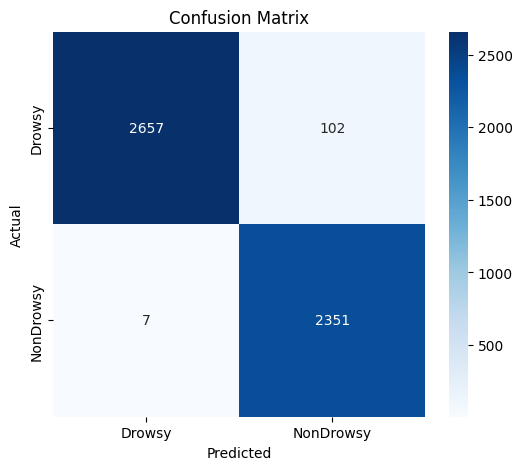

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# ✅ Extract final training accuracy & loss from history
final_train_acc = history.history['accuracy'][-1]
final_train_loss = history.history['loss'][-1]

print(f"\n✅ Final Training Accuracy: {final_train_acc:.4f}")
print(f"❌ Final Training Loss: {final_train_loss:.4f}")

# ✅ Evaluate final model on validation generator
val_loss, val_acc = model.evaluate(val_gen, verbose=1)
print(f"\n✅ Final Validation Accuracy: {val_acc:.4f}")
print(f"❌ Final Validation Loss: {val_loss:.4f}")

# 📊 Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# 🧠 Predict and generate classification report
y_true = []
y_pred = []

for X_batch, y_batch in val_gen:
    preds = model.predict(X_batch)
    y_true.extend(y_batch)
    y_pred.extend((preds > 0.5).astype(int).flatten())
    if len(y_true) >= len(val_keys):
        break

print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=CLASSES))

# 🔳 Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [7]:
# 📦 Imports
import os, cv2, numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
from tensorflow.keras import layers, Input, Model

# 📂 Dataset path
DATASET_DIR = '../../ProcessedFusionFull'
CLASSES = ['Drowsy', 'NonDrowsy']
IMG_SIZE = 256
BATCH_SIZE = 16
EPOCHS = 15

# 🧠 Custom Data Generator
class FusionDataGenerator(Sequence):
    def __init__(self, base_dir, keys, label_dict, batch_size=8, img_size=128, shuffle=True):
        self.face_dir = {cls: os.path.join(base_dir, cls, 'face') for cls in CLASSES}
        self.dot_dir  = {cls: os.path.join(base_dir, cls, 'dotmap') for cls in CLASSES}
        self.lmk_dir  = {cls: os.path.join(base_dir, cls, 'landmark') for cls in CLASSES}
        self.keys = keys
        self.label_dict = label_dict
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.keys) // self.batch_size

    def __getitem__(self, idx):
        batch_keys = self.keys[idx * self.batch_size:(idx + 1) * self.batch_size]
        Xf, Xd, Xm, y = [], [], [], []

        for key in batch_keys:
            label = self.label_dict[key]
            cls = CLASSES[label]
            face = cv2.imread(os.path.join(self.face_dir[cls], key + '.png'), cv2.IMREAD_GRAYSCALE)
            dot  = cv2.imread(os.path.join(self.dot_dir[cls], key + '.png'), cv2.IMREAD_GRAYSCALE)
            lmk  = np.load(os.path.join(self.lmk_dir[cls], key + '.npy'))

            if face is None or dot is None or lmk.shape[0] != 478:
                continue

            face = cv2.resize(face, (self.img_size, self.img_size)) / 255.0
            dot  = cv2.resize(dot,  (self.img_size, self.img_size)) / 255.0

            Xf.append(face[..., np.newaxis])
            Xd.append(dot[..., np.newaxis])
            Xm.append(lmk.flatten())
            y.append(label)

        return {
            'face_in': np.array(Xf, dtype=np.float32),
            'dot_in':  np.array(Xd, dtype=np.float32),
            'lmk_in':  np.array(Xm, dtype=np.float32)
        }, np.array(y, dtype=np.float32)


    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.keys)

# 🏷️ Create label dictionary
label_dict = {}
for idx, cls in enumerate(CLASSES):
    face_path = os.path.join(DATASET_DIR, cls, 'face')
    for fname in os.listdir(face_path):
        if fname.endswith('.png'):
            key = os.path.splitext(fname)[0]
            label_dict[key] = idx

# 🔀 Split data
keys = list(label_dict.keys())
train_keys, val_keys = train_test_split(keys, test_size=0.3, stratify=[label_dict[k] for k in keys], random_state=42)

# 📤 Create generators
train_gen = FusionDataGenerator(DATASET_DIR, train_keys, label_dict, batch_size=BATCH_SIZE, img_size=IMG_SIZE)
val_gen   = FusionDataGenerator(DATASET_DIR, val_keys, label_dict, batch_size=BATCH_SIZE, img_size=IMG_SIZE)

# 🧠 Model definition
landmark_dim = 478 * 2

face_in = Input(shape=(IMG_SIZE, IMG_SIZE, 1), name='face_in')
x1 = layers.Conv2D(32, 3, activation='relu')(face_in)
x1 = layers.MaxPooling2D()(x1)
x1 = layers.Conv2D(64, 3, activation='relu')(x1)
x1 = layers.GlobalAveragePooling2D()(x1)
x1 = layers.Dense(128, activation='relu')(x1)

dot_in = Input(shape=(IMG_SIZE, IMG_SIZE, 1), name='dot_in')
x2 = layers.Conv2D(32, 3, activation='relu')(dot_in)
x2 = layers.MaxPooling2D()(x2)
x2 = layers.Conv2D(64, 3, activation='relu')(x2)
x2 = layers.GlobalAveragePooling2D()(x2)
x2 = layers.Dense(128, activation='relu')(x2)

lmk_in = Input(shape=(landmark_dim,), name='lmk_in')
x3 = layers.Dense(128, activation='relu')(lmk_in)
x3 = layers.Dense(64, activation='relu')(x3)

merged = layers.concatenate([x1, x2, x3])
z = layers.Dense(64, activation='relu')(merged)
z = layers.Dropout(0.4)(z)
out = layers.Dense(1, activation='sigmoid', name='out')(z)

model = Model(inputs=[face_in, dot_in, lmk_in], outputs=out)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# 🚀 Train
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS
)

# 💾 Save
model.save("fatigue_fusion_model_generator_70.h5")


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ face_in             │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_in (InputLayer) │ (None, 256, 256,  │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 254, 254,  │        320 │ face_in[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 254, 254,  │        320 │ dot_in[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 127, 127,  │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 127, 127,  │          0 │ conv2d_10[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 125, 125,  │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 125, 125,  │     18,496 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lmk_in (InputLayer) │ (None, 956)       │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ conv2d_9[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ conv2d_11[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 128)       │    122,496 │ lmk_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 128)       │      8,320 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 128)       │      8,320 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 64)        │      8,256 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 320)       │          0 │ dense_10[0][0],   │
│ (Concatenate)       │                   │            │ dense_11[0][0],   │
│                     │                   │            │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 64)        │     20,544 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ out (Dense)         │ (None, 1)         │         65 │ dropout_2[0][0] 

 Total params: 205,633 (803.25 KB)

 Trainable params: 205,633 (803.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15


c:\Users\aqilw\Desktop\FYP DEGREE\FatigueFYP\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1119/1119 ━━━━━━━━━━━━━━━━━━━━ 531s 473ms/step - accuracy: 0.5889 - loss: 0.6709 - val_accuracy: 0.7362 - val_loss: 0.5129
Epoch 2/15
1119/1119 ━━━━━━━━━━━━━━━━━━━━ 528s 472ms/step - accuracy: 0.7259 - loss: 0.5284 - val_accuracy: 0.8045 - val_loss: 0.4291
Epoch 3/15
1119/1119 ━━━━━━━━━━━━━━━━━━━━ 527s 471ms/step - accuracy: 0.7736 - loss: 0.4536 - val_accuracy: 0.8287 - val_loss: 0.3678
Epoch 4/15
1119/1119 ━━━━━━━━━━━━━━━━━━━━ 530s 474ms/step - accuracy: 0.8377 - loss: 0.3781 - val_accuracy: 0.8770 - val_loss: 0.2733
Epoch 5/15
1119/1119 ━━━━━━━━━━━━━━━━━━━━ 531s 475ms/step - accuracy: 0.8923 - loss: 0.3012 - val_accuracy: 0.9338 - val_loss: 0.2309
Epoch 6/15
1119/1119 ━━━━━━━━━━━━━━━━━━━━ 528s 472ms/step - accuracy: 0.9024 - loss: 0.2743 - val_accuracy: 0.9002 - val_loss: 0.2500
Epoch 7/15
1119/1119 ━━━━━━━━━━━━━━━━━━━━ 529s 473ms/step - accuracy: 0.9191 - loss: 0.2326 - val_accuracy: 0.9532 - val_loss: 0.1546
Epoch 8/15
1119/1119 ━━━━━━━━━━━━━━━━━━━━ 527s 471ms/step - accuracy: 0.9

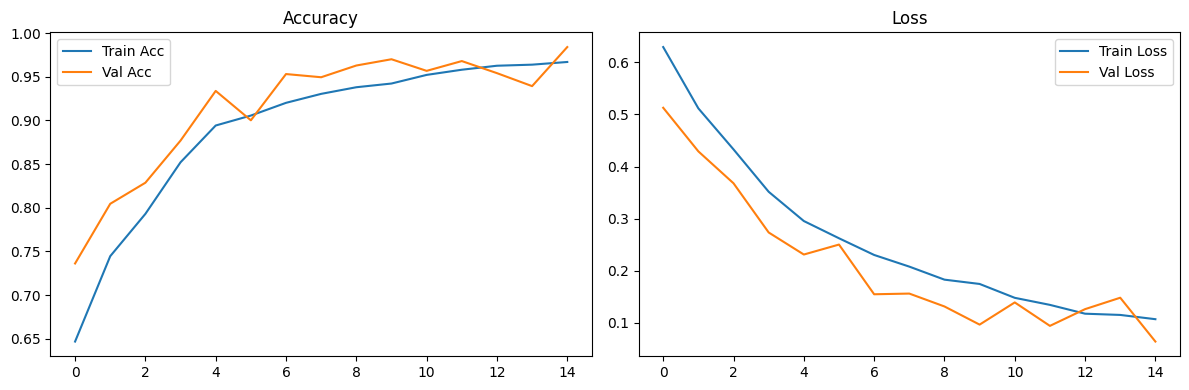

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()
    


✅ Final Training Accuracy: 0.9670
❌ Final Training Loss: 0.1066
479/479 ━━━━━━━━━━━━━━━━━━━━ 59s 122ms/step - accuracy: 0.9826 - loss: 0.0654

✅ Final Validation Accuracy: 0.9841
❌ Final Validation Loss: 0.0637


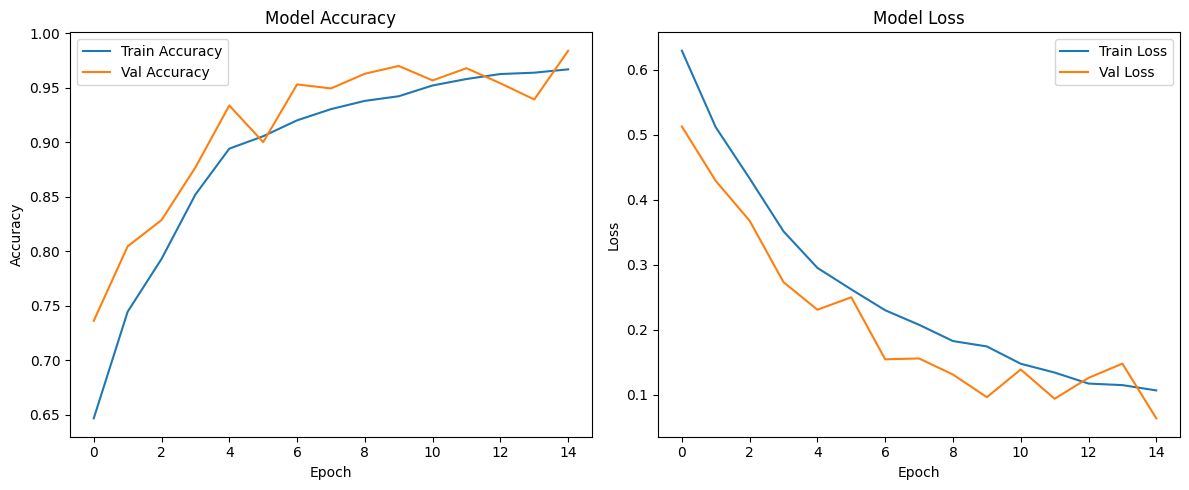

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

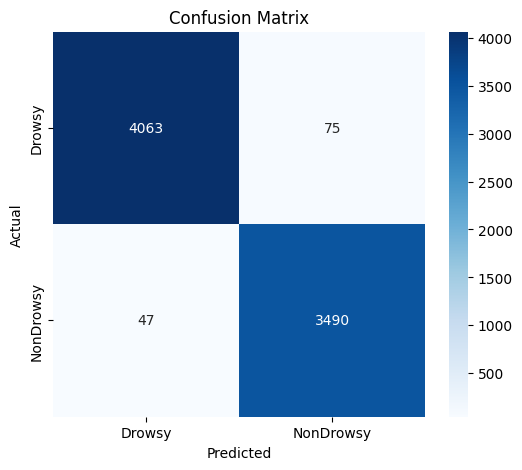

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# ✅ Extract final training accuracy & loss from history
final_train_acc = history.history['accuracy'][-1]
final_train_loss = history.history['loss'][-1]

print(f"\n✅ Final Training Accuracy: {final_train_acc:.4f}")
print(f"❌ Final Training Loss: {final_train_loss:.4f}")

# ✅ Evaluate final model on validation generator
val_loss, val_acc = model.evaluate(val_gen, verbose=1)
print(f"\n✅ Final Validation Accuracy: {val_acc:.4f}")
print(f"❌ Final Validation Loss: {val_loss:.4f}")

# 📊 Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# 🧠 Predict and generate classification report
y_true = []
y_pred = []

for X_batch, y_batch in val_gen:
    preds = model.predict(X_batch)
    y_true.extend(y_batch)
    y_pred.extend((preds > 0.5).astype(int).flatten())
    if len(y_true) >= len(val_keys):
        break

print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=CLASSES))

# 🔳 Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
